A intenção deste notebook é integrar todas as bibliotecas e técnicas de otimização hiperparamétrica em apenas um documento, com comparação entre os métodos estudados

### Instalação

In [ ]:
#Bayes opt
!pip install scikit-optimize

In [ ]:
#evolutionary opt
!pip install tpot

In [ ]:
#pbt
!pip install parameter-sherpa

In [ ]:
#Optuna
!pip install optuna

### Importação das bibliotecas

In [45]:
#bibliotecas padrão
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns

#Importando modelos
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

#Importando bibliotecas de otimização
#Grid e Random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#Bayes
from skopt import BayesSearchCV
#Evolutionary
from tpot import TPOTRegressor as TPR
#PBT
import sherpa
#Optuna
import optuna

### Lendo dados

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def read_df():
  df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/SI_1_test.csv')
  df_test.drop(columns='Unnamed: 0', inplace=True)

  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/SI_1_train.csv')
  df_train.drop(columns='Unnamed: 0', inplace=True)

  X_test = df_test.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
  y_test = df_test.loc[:, 'Target'].tolist()

  X_train = df_train.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
  y_train = df_train.loc[:, 'Target'].tolist()

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = read_df()

### Definição dos espaços hiperparamétricos

A distribuição dos espaços hiperparamétricos para cada modelo será feita em duas partes, uma considerando o método Grid Search e outra para os demais métodos.

As funções para definição dos espaços hiperparamétricos receberão apenas o nome do modelo e do método de otimização e retornarão o espaço referente.

In [33]:
#Esta função contém todo o espaço hiperparamétrico, é muito grande para a busca do tipo Grid Search
def hyperparameter_space (name, optimizer):

  space = {}

  if optimizer == 'Grid':

    if name == 'SVM':

      kernel = ['rbf','linear']
      C = (np.arange(1,10)/10).tolist() #0.1 - 0.9 - 0.1

      epsilon = [] #0.001 - 0.9
      for j in range(1,4): 
        for i in range(1,10):
          epsilon.append(i/(10**j))

      space = {'kernel': kernel, 'C':C, 'epsilon':epsilon}

    elif name == 'KNN':

      n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
      weights = ['uniform','distance']
      p = [1,2]

      space = {'n_neighbors':n_n, 'weights':weights, 'p':p }

    elif name == 'DecisionTree':

      min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
      max_feat = (np.arange(50,100,5)/100).tolist() #0.5 - 0.95 - 0.05
      max_depth = (np.arange(10,100,10)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
      criterion = ['mse','friedman_mse','mae']
      spliter = ['best']

      space = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}

    elif name == 'RandomForest':

      n_est = (np.arange(50,751, 10)).tolist() #50 - 750 - 10
      min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
      max_feat = (np.arange(20,100,5)/100).tolist() #0.2 - 0.95 - 0.0
      criterion = ['mse','mae']
      max_dpt = (np.arange(10,100,10)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
      max_samp = (np.arange(50,100,5)/100).tolist() #0.5 - 0.99
      oob = [True,False]
      
      space = {'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_dpt,
              'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 'criterion':criterion, 'oob_score':oob}
      
    elif name == 'AdaBoost':

      n_est = (np.arange(50,751,10)).tolist() #50 - 750
      loss = ['linear','exponential','square']

      lr = [] #0.001 - 0.9
      for j in range(1,4): 
        for i in range(1,10):
          lr.append(i/(10**j))

      space = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}

    elif name == 'GradientBoost':

      n_est = (np.arange(50,751,10)).tolist() #50 - 750
      min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
      sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
      criterion = ['mse','friedman_mse','mae']
      min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
      max_feat = (np.arange(20,100,5)/100).tolist() #0.2 - 0.95 - 0.05
      max_dpt = (np.arange(10,100,10)).tolist() #10 - 100
      alpha = (np.arange(50,100,10)/100).tolist() #0.5 - 0.99

      lr = [0.005, 0.006, 0.007, 0.008, 0.009] #0.001 - 0.9
      for j in range(1,3): 
        for i in range(1,10):
          lr.append(i/(10**j))

      space = [
            {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
              'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['ls', 'lad'] },
            {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
              'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['huber', 'quantile'], 'alpha': alpha}
      ]

    elif name == 'XGBoost':

      n_est = (np.arange(50,751,10)).tolist() #50 - 750
      bst = ['gbtree','gblinear','dart']

      lr = [] #0.001 - 0.9
      for j in range(1,4): 
        for i in range(1,10):
          lr.append(i/(10**j))
      
      space = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}

  elif optimizer == 'Random' or optimizer == 'Bayes':

    if name == 'SVM':

      kernel = ['rbf','linear']
      C = (np.arange(10,100)/100).tolist() #0.1 - 0.99
      epsilon = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999

      space = {'kernel': kernel, 'C':C, 'epsilon':epsilon}

    elif name == 'KNN':

      n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
      weights = ['uniform','distance']
      p = [1,2]

      space = {'n_neighbors':n_n, 'weights':weights, 'p':p }

    elif name == 'DecisionTree':

      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      max_feat = (np.arange(50,100)/100).tolist() #0.5 - 0.99
      max_depth = (np.arange(10,100)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      criterion = ['mse','friedman_mse','mae']
      spliter = ['best']

      space = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}

    elif name == 'RandomForest':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
      criterion = ['mse','mae']
      max_dpt = (np.arange(10,100)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      max_samp = (np.arange(50,100)/100).tolist() #0.5 - 0.99
      oob = [True,False]
      
      space = {'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_dpt,
              'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 'criterion':criterion, 'oob_score':oob}
      
    elif name == 'AdaBoost':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      lr = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
      loss = ['linear','exponential','square']

      space = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}

    elif name == 'GradientBoost':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
      lr = (np.arange(5,1000)/1000).tolist() # 0.005 - 0.999
      criterion = ['mse','friedman_mse','mae']
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
      max_dpt = (np.arange(10,100)).tolist() #10 - 100
      alpha = (np.arange(50,100)/100).tolist() #0.5 - 0.99

      space = [
            {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
              'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['ls', 'lad'] },
            {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
              'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['huber', 'quantile'], 'alpha': alpha}
      ]

    elif name == 'XGBoost':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      lr = (np.arange(1,100)/100).tolist() # 0.01 - 0.99
      bst = ['gbtree','gblinear','dart']
      
      space = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}

  elif optimizer == 'Evolutionary':

    if name == 'SVM':

      kernel = ['rbf','linear']
      C = (np.arange(10,100)/100).tolist() #0.1 - 0.99
      epsilon = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999

      space = {'sklearn.svm.SVR':{'kernel': kernel, 'C':C, 'epsilon':epsilon}}

    elif name == 'KNN':

      n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
      weights = ['uniform','distance']
      p = [1,2]

      space = {'sklearn.neighbors.KNeighborsRegressor':{'n_neighbors':n_n, 'weights':weights, 'p':p }}

    elif name == 'DecisionTree':

      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      max_feat = (np.arange(50,100)/100).tolist() #0.5 - 0.99
      max_depth = (np.arange(10,100)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      criterion = ['mse','friedman_mse','mae']
      spliter = ['best']

      space = {'sklearn.tree.DecisionTreeRegressor':{'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}}

    elif name == 'RandomForest':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
      criterion = ['mse','mae']
      max_dpt = (np.arange(10,100)).tolist() #10 - 100
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      max_samp = (np.arange(50,100)/100).tolist() #0.5 - 0.99
      oob = [True,False]
      
      space = {'sklearn.ensemble.RandomForestRegressor':{'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 
                                                        'max_depth':max_dpt, 'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 
                                                        'criterion':criterion, 'oob_score':oob}}
      
    elif name == 'AdaBoost':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      lr = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
      loss = ['linear','exponential','square']

      space = {'sklearn.ensemble.AdaBoostRegressor':{'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}}

    elif name == 'GradientBoost':

      #TPOT não suporta mais de um dicionário como entrada

      n_est = (np.arange(50,751)).tolist() #50 - 750
      min_s_split = (np.arange(2,21)).tolist() #1 - 20
      sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
      lr = (np.arange(5,1000)/1000).tolist() # 0.005 - 0.999
      criterion = ['mse','friedman_mse','mae']
      min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
      max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
      max_dpt = (np.arange(10,100)).tolist() #10 - 100
      alpha = (np.arange(50,100)/100).tolist() #0.5 - 0.99

      space = {'sklearn.ensemble.GradientBoostingRegressor':{'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 
            'criterion': criterion, 'min_samples_leaf': min_s_leaf, 'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 
            'loss': ['ls', 'lad','huber', 'quantile'], 'alpha': alpha}}

    elif name == 'XGBoost':

      n_est = (np.arange(50,751)).tolist() #50 - 750
      lr = (np.arange(1,100)/100).tolist() # 0.01 - 0.99
      bst = ['gbtree','gblinear','dart']
      
      space = {'xgboost.XGBRegressor':{'n_estimators':n_est, 'learning_rate':lr,'booster':bst}}


  elif optimizer == "PBT":

    if name == 'SVM':

      space = {sherpa.Choice('kernel',['rbf','linear']),
              sherpa.Continuous('C',[0.1,0.99]),
              sherpa.Continuous('epsilon',[0.001,0.999])}

    elif name == 'KNN':

      space = {sherpa.Discrete('n_neighbors',[5,13]),
              sherpa.Choice('weights',['uniform','distance']),
              sherpa.Discrete('p',[1,2])}

    elif name == 'DecisionTree':

      space = {sherpa.Discrete('min_samples_split',[2,20]),
              sherpa.Continuous('max_features',[0.5,0.99]),
              sherpa.Discrete('max_depth',[10,100]), 
              sherpa.Choice('criterion',['mse','friedman_mse','mae']),
              sherpa.Choice('splitter',['best']),
              sherpa.Continuous('min_samples_leaf',[0.05,0.2])}

    elif name == 'RandomForest':
      
      space = {sherpa.Discrete('n_estimators',[50,750]), 
              sherpa.Discrete('min_samples_split',[2,20]), 
              sherpa.Continuous('max_features',[0.2,0.9]), 
              sherpa.Discrete('max_depth',[10,100]),
              sherpa.Continuous('min_samples_leaf',[0.05,0.2]), 
              sherpa.Continuous('max_samples',[0.5,0.99]), 
              sherpa.Choice('criterion',['mse','mae']), 
              sherpa.Choice('oob_score',[True,False])}
      
    elif name == 'AdaBoost':

      space = {sherpa.Discrete('n_estimators',[50,750]),
              sherpa.Continuous('learning_rate',[0.001,0.999]),
              sherpa.Choice('loss',['linear','exponential','square'])}

    elif name == 'GradientBoost':

      space = {sherpa.Discrete('n_estimators',[50,750]), 
              sherpa.Continuous('learning_rate',[0.005,0.999]), 
              sherpa.Discrete('min_samples_split',[2,20]), 
              sherpa.Choice('criterion',['mse','friedman_mse','mae']), 
              sherpa.Continuous('min_samples_leaf',[0.05,0.2]), 
              sherpa.Discrete('max_depth',[10,100]), 
              sherpa.Continuous('subsample',[0.5,0.9]), 
              sherpa.Continuous('max_features',[0.2,0.9]), 
              sherpa.Choice('loss',['ls', 'lad','huber', 'quantile']), 
              sherpa.Continuous('alpha',[0.5,0.99])}

    elif name == 'XGBoost':
      
      space = {sherpa.Discrete('n_estimators',[50,750]), 
              sherpa.Continuous('learning_rate',[0.01,0.99]),
              sherpa.Choice('booster',['gbtree','gblinear','dart'])}

  return space 

### Grid Search

#### Classe

In [26]:
class Grid():
  def __init__(self, name, hyp):
    self.time = 0
    self.time_tuned = 0
    self.time_default = 0
    self.score = 0
    self.score_default = 0
    self.score_tuned = 0
    self.hyp = hyp
    self.name = name
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Random Search")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print("Padrão: ", self.score_default)
    print("Ajustado: ", self.score_tuned)
    print("Relativa: ", self.score)
    print("----TEMPOS----")
    print("Padrão: ", self.time_default)
    print("Ajustado: ", self.time_tuned)
    print("Relativo: ", self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def GridSearch(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test

    #definindo model de acordo com modelo selecionado
    if self.name == 'SVM':
      self.model = SVR()
      
    elif self.name == 'KNN':
      self.model = KNR()

    elif self.name == 'DecisionTree':
      self.model = DecisionTreeRegressor()

    elif self.name == 'RandomForest':
      self.model = RandomForestRegressor()
      
    elif self.name == 'AdaBoost':
      self.model = AdaBoostRegressor()

    elif self.name == 'GradientBoost':
      self.model = GradientBoostingRegressor()

    elif self.name == 'XGBoost':
      self.model = XGBRegressor()

    else:
      return 0

    self.model_tuned = GridSearchCV(self.model, self.hyp, verbose=3)

    #treinamento do modelo padrão
    ini_default = time.time()
    self.model.fit(self.X_train, self.y_train)
    fim_default = time.time()

    #treinamento do modelo otimizado
    ini_tuned = time.time()
    self.model_tuned.fit(self.X_train, self.y_train)
    fim_tuned = time.time()

    #Cálculo do tempo relativo
    self.time_default = fim_default - ini_default 
    self.time_tuned = fim_tuned - ini_tuned 
    self.time = self.time_tuned / self.time_default

    #Cálculo da pontuação relativa
    self.score_default = self.model.score(self.X_test, self.y_test)
    self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)
    self.score = self.score_tuned/self.score_default

    #Dicionário com melhores HP
    self.best_hp = self.model_tuned.best_params_

In [ ]:
hyp = hyperparameter_space('SVM','Grid')
gs = Grid('SVM', hyp)
gs.GridSearch(X_train, X_test, y_train, y_test)
gs.report()

### Random Search

#### Classe

In [ ]:
class Random():
  def __init__(self, name, hyp):
    self.time = 0
    self.time_tuned = 0
    self.time_default = 0
    self.score = 0
    self.score_default = 0
    self.score_tuned = 0
    self.hyp = hyp
    self.n_iter = 60
    self.name = name
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Random Search")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print("Padrão: ", self.score_default)
    print("Ajustado: ", self.score_tuned)
    print("Relativa: ", self.score)
    print("----TEMPOS----")
    print("Padrão: ", self.time_default)
    print("Ajustado: ", self.time_tuned)
    print("Relativo: ", self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def RandomSearch(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test

    #definindo model de acordo com modelo selecionado
    if self.name == 'SVM':
      self.model = SVR()
      
    elif self.name == 'KNN':
      self.model = KNR()

    elif self.name == 'DecisionTree':
      self.model = DecisionTreeRegressor()

    elif self.name == 'RandomForest':
      self.model = RandomForestRegressor()
      
    elif self.name == 'AdaBoost':
      self.model = AdaBoostRegressor()

    elif self.name == 'GradientBoost':
      self.model = GradientBoostingRegressor()

    elif self.name == 'XGBoost':
      self.model = XGBRegressor()

    else:
      return 0

    self.model_tuned = RandomizedSearchCV(self.model, self.hyp, n_iter= self.n_iter, verbose=1)

    #treinamento do modelo padrão
    ini_default = time.time()
    self.model.fit(self.X_train, self.y_train)
    fim_default = time.time()

    #treinamento do modelo otimizado
    ini_tuned = time.time()
    self.model_tuned.fit(self.X_train, self.y_train)
    fim_tuned = time.time()

    #Cálculo do tempo relativo
    self.time_default = fim_default - ini_default 
    self.time_tuned = fim_tuned - ini_tuned 
    self.time = self.time_tuned / self.time_default

    #Cálculo da pontuação relativa
    self.score_default = self.model.score(self.X_test, self.y_test)
    self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)
    self.score = self.score_tuned/self.score_default

    #Dicionário com melhores HP
    self.best_hp = self.model_tuned.best_params_

In [ ]:
hyp = hyperparameter_space('SVM','Random')
rs = Random('SVM', hyp)
rs.RandomSearch(X_train, X_test, y_train, y_test)
rs.report()

### Bayesian OPT

#### Classe

In [ ]:
class Bayes():
  def __init__(self, name, hyp):
    self.time = 0
    self.time_tuned = 0
    self.time_default = 0
    self.score = 0
    self.score_default = 0
    self.score_tuned = 0
    self.hyp = hyp
    self.n_iter = 60
    self.name = name
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Bayes")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print("Padrão: ", self.score_default)
    print("Ajustado: ", self.score_tuned)
    print("Relativa: ", self.score)
    print("----TEMPOS----")
    print("Padrão: ", self.time_default)
    print("Ajustado: ", self.time_tuned)
    print("Relativo: ", self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def BayesianSearch(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test

    #definindo model de acordo com modelo selecionado
    if self.name == 'SVM':
      self.model = SVR()
      
    elif self.name == 'KNN':
      self.model = KNR()

    elif self.name == 'DecisionTree':
      self.model = DecisionTreeRegressor()

    elif self.name == 'RandomForest':
      self.model = RandomForestRegressor()
      
    elif self.name == 'AdaBoost':
      self.model = AdaBoostRegressor()

    elif self.name == 'GradientBoost':
      self.model = GradientBoostingRegressor()

    elif self.name == 'XGBoost':
      self.model = XGBRegressor()

    else:
      return 0

    self.model_tuned = BayesSearchCV(self.model, self.hyp, n_iter= self.n_iter, verbose=1)

    #treinamento do modelo padrão
    ini_default = time.time()
    self.model.fit(self.X_train, self.y_train)
    fim_default = time.time()

    #treinamento do modelo otimizado
    ini_tuned = time.time()
    self.model_tuned.fit(self.X_train, self.y_train)
    fim_tuned = time.time()

    #Cálculo do tempo relativo
    self.time_default = fim_default - ini_default 
    self.time_tuned = fim_tuned - ini_tuned 
    self.time = self.time_tuned / self.time_default

    #Cálculo da pontuação relativa
    self.score_default = self.model.score(self.X_test, self.y_test)
    self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)
    self.score = self.score_tuned/self.score_default

    #Dicionário com melhores HP
    self.best_hp = self.model_tuned.best_params_

In [ ]:
hyp = hyperparameter_space("SVM","Bayes")
bay = Bayes("SVM", hyp)
bay.BayesianSearch(X_train, X_test, y_train, y_test)
bay.report()

### Evolutionary optimization

#### Classe

In [ ]:
class Evolutionary():
  def __init__(self, name, hyp):
    self.time = 0
    self.time_tuned = 0
    self.time_default = 0
    self.score = 0
    self.score_default = 0
    self.score_tuned = 0
    self.hyp = hyp
    self.generations = 10
    self.pop_size = 100
    self.scoring = 'r2'
    self.name = name
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Evolutionary")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print("Padrão: ", self.score_default)
    print("Ajustado: ", self.score_tuned)
    print("Relativa: ", self.score)
    print("----TEMPOS----")
    print("Padrão: ", self.time_default)
    print("Ajustado: ", self.time_tuned)
    print("Relativo: ", self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def EvolutionaryOpt(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test

    #definindo model de acordo com modelo selecionado
    if self.name == 'SVM':
      self.model = SVR()
      
    elif self.name == 'KNN':
      self.model = KNR()

    elif self.name == 'DecisionTree':
      self.model = DecisionTreeRegressor()

    elif self.name == 'RandomForest':
      self.model = RandomForestRegressor()
      
    elif self.name == 'AdaBoost':
      self.model = AdaBoostRegressor()

    elif self.name == 'GradientBoost':
      self.model = GradientBoostingRegressor()

    elif self.name == 'XGBoost':
      self.model = XGBRegressor()

    else:
      return 0

    self.model_tuned = TPR(generations= self.generations, population_size= self.pop_size, random_state=1, 
                           config_dict=self.hyp, cv= 5, verbosity = 1, scoring=self.scoring)

    #treinamento do modelo padrão
    ini_default = time.time()
    self.model.fit(self.X_train, self.y_train)
    fim_default = time.time()

    #treinamento do modelo otimizado
    ini_tuned = time.time()

    self.X_train = np.array(self.X_train, dtype=np.float32)
    self.y_train = np.array(self.y_train, dtype=np.float32)

    self.model_tuned.fit(self.X_train, self.y_train)
    fim_tuned = time.time()

    #Cálculo do tempo relativo
    self.time_default = fim_default - ini_default 
    self.time_tuned = fim_tuned - ini_tuned 
    self.time = self.time_tuned / self.time_default

    #Cálculo da pontuação relativa
    self.score_default = self.model.score(self.X_test, self.y_test)

    self.X_test = np.array(self.X_test, dtype=np.float32)
    self.y_test = np.array(self.y_test, dtype=np.float32)

    self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)

    self.score = self.score_tuned/self.score_default

In [ ]:
hp_a = hyperparameter_space("KNN","Evolutionary")
ev = Evolutionary("KNN", hp_a)
ev.EvolutionaryOpt(X_train, X_test, y_train, y_test)
ev.report()

### Population Based Training

#### Classe

In [ ]:
class PBT():
  def __init__(self, name, hyp):
    self.time = 0
    self.time_tuned = 0
    self.time_default = 0
    self.score = 0
    self.score_default = 0
    self.score_tuned = 0
    self.hyp = hyp
    self.pop = 100
    self.gen = 10
    self.name = name
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
    self.algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=self.pop,
                                                              num_generations=self.gen, perturbation_factors=(0.8, 1.2))
    
    self.study = sherpa.Study(parameters=self.hyp, algorithm=self.algorithm, disable_dashboard = True, lower_is_better=False)

    self.model_def = None

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Population Based Training")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print("Padrão: ", self.score_default)
    print("Ajustado: ", self.score_tuned)
    print("Relativa: ", self.score)
    print("----TEMPOS----")
    print("Padrão: ", self.time_default)
    print("Ajustado: ", self.time_tuned)
    print("Relativo: ", self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def function_opt(self):
    for trial in self.study:
        generation = trial.parameters['generation']

        print("-"*100)
        print("Generation {}".format(generation))
        print("Trial ", trial.id, " with parameters ", trial.parameters)
        
        # Criando modelo
        if self.name == 'SVM' :
            self.model = SVR(C=trial.parameters['C'], epsilon = trial.parameters['epsilon'], kernel=trial.parameters['kernel'])
            self.model_def = SVR()
        
        elif self.name == 'KNN':
          self.model = KNR(n_neighbors = trial.parameters['n_neighbors'] ,weights = trial.parameters['weights'] ,p = trial.parameters['p'])
          self.model_def = KNR()

        elif self.name == 'DecisionTree':
          self.model = DecisionTreeRegressor(min_samples_split = trial.parameters['min_samples_split'],
                                             max_features = trial.parameters['max_features'],
                                             max_depth = trial.parameters['max_depth'],
                                             criterion = trial.parameters['criterion'],
                                             splitter = trial.parameters['splitter'],
                                             min_samples_leaf = trial.parameters['min_samples_leaf'])
          self.model_def = DecisionTreeRegressor()

        elif self.name == 'RandomForest':
          self.model = RandomForestRegressor(n_estimators = trial.parameters['n_estimators'],
                                              min_samples_split = trial.parameters['min_samples_split'],
                                              max_features = trial.parameters['max_features'],
                                              max_depth = trial.parameters['max_depth'],
                                              min_samples_leaf = trial.parameters['min_samples_leaf'],
                                              max_samples = trial.parameters['max_samples'],
                                              criterion = trial.parameters['criterion'],
                                              oob_score = trial.parameters['oob_score'])
          self.model_def = RandomForestRegressor()
          
        elif self.name == 'AdaBoost':
          self.model = AdaBoostRegressor(n_estimators = trial.parameters['n_estimators'],
                                          learning_rate = trial.parameters['learning_rate'],
                                          loss = trial.parameters['loss'])
          self.model_def = AdaBoostRegressor()

        elif self.name == 'GradientBoost':
          self.model = GradientBoostingRegressor(n_estimators = trial.parameters['n_estimators'],
                                                  learning_rate = trial.parameters['learning_rate'],
                                                  min_samples_split = trial.parameters['min_samples_split'],
                                                  criterion = trial.parameters['criterion'],
                                                  min_samples_leaf = trial.parameters['min_samples_leaf'],
                                                  max_depth = trial.parameters['max_depth'],
                                                  subsample = trial.parameters['subsample'],
                                                  max_features = trial.parameters['max_features'],
                                                  loss = trial.parameters['loss'],
                                                  alpha = trial.parameters['alpha'])
          self.model_def = GradientBoostingRegressor()

        elif self.name == 'XGBoost':
          self.model = XGBRegressor(n_estimators = trial.parameters['n_estimators'],
                                    learning_rate = trial.parameters['learning_rate'],
                                    booster = trial.parameters['booster'])
          self.model_def = XGBRegressor()

        else:
          return 0
        
        self.model.fit(self.X_train, self.y_train)
        self.score_tuned_part = self.model.score(self.X_test, self.y_test)

        print("Validation accuracy: ", self.score_tuned_part)
        self.study.add_observation(trial=trial, iteration=generation,
                              objective=self.score_tuned_part)
        self.study.finalize(trial=trial)
    return self.study.get_best_result()


  def PBT_opt(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test
    
    #treinamento do modelo otimizado
    ini_tuned = time.time()
    pbt_model = self.function_opt()
    fim_tuned = time.time()
    
    #treinamento do modelo padrão
    ini_default = time.time()
    self.model_def.fit(self.X_train, self.y_train)
    fim_default = time.time()

    #Cálculo do tempo relativo
    self.time_default = fim_default - ini_default 
    self.time_tuned = fim_tuned - ini_tuned 
    self.time = self.time_tuned / self.time_default

    #Cálculo da pontuação relativa
    self.score_default = self.model_def.score(self.X_test, self.y_test)
    self.score_tuned = self.model.score(self.X_test, self.y_test)
    self.score = self.score_tuned/self.score_default

In [ ]:
hyp_dict = hyperparameter_space("SVM", "PBT")
pbt_obj = PBT("SVM",hyp_dict)
pbt_obj.PBT_opt(X_train, X_test, y_train, y_test)
pbt_obj.report()

### Optuna

#### Classe

In [72]:
class OPTUNA():
  def __init__(self):
    self.time = 0
    self.score = 0
    self.best_hp = {}
    self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

  def hyperspace(self, name, trial):
    if name == 'SVM':

      space = {'kernel_svm':trial.suggest_categorical('kernel_svm',['rbf','linear']),
              'C':trial.suggest_float('C',0.1,0.99),
              'epsilon':trial.suggest_float('epsilon',0.001,0.999)}

    elif name == 'KNN':

      space = {'n_neighbors':trial.suggest_int('n_neighbors',5,13),
              'weights_knn':trial.suggest_categorical('weights_knn',['uniform','distance']),
              'p':trial.suggest_int('p',1,2)}

    elif name == 'DecisionTree':

      space = {'min_samples_split':trial.suggest_int('min_samples_split',2,20),
              'max_features':trial.suggest_float('max_features',0.5,0.99),
              'max_depth':trial.suggest_int('max_depth',10,100), 
              'criterion_dt':trial.suggest_categorical('criterion_dt',['mse','friedman_mse','mae']),
              'splitter_dt':trial.suggest_categorical('splitter_dt',['best']),
              'min_samples_leaf':trial.suggest_float('min_samples_leaf',0.05,0.2)}

    elif name == 'RandomForest':
      
      space = {'n_estimators':trial.suggest_int('n_estimators',50,750), 
              'min_samples_split':trial.suggest_int('min_samples_split',2,20), 
              'max_features':trial.suggest_float('max_features',0.2,0.9), 
              'max_depth':trial.suggest_int('max_depth',10,100),
              'min_samples_leaf':trial.suggest_float('min_samples_leaf',0.05,0.2), 
              'max_samples':trial.suggest_float('max_samples',0.5,0.99), 
              'criterion_rf':trial.suggest_categorical('criterion_rf',['mse','mae']), 
              'oob_score_rf':trial.suggest_categorical('oob_score_rf',[True,False])}
      
    elif name == 'AdaBoost':

      space = {'n_estimators':trial.suggest_int('n_estimators',50,750),
              'learning_rate':trial.suggest_float('learning_rate',0.001,0.999),
              'loss_adb':trial.suggest_categorical('loss_adb',['linear','exponential','square'])}

    elif name == 'GradientBoost':

      space = {'n_estimators':trial.suggest_int('n_estimators',50,750), 
              'learning_rate':trial.suggest_float('learning_rate',0.005,0.999), 
              'min_samples_split':trial.suggest_int('min_samples_split',2,20), 
              'criterion_gdb':trial.suggest_categorical('criterion_gdb',['mse','friedman_mse','mae']), 
              'min_samples_leaf':trial.suggest_float('min_samples_leaf',0.05,0.2), 
              'max_depth':trial.suggest_int('max_depth',10,100), 
              'subsample':trial.suggest_float('subsample',0.5,0.9), 
              'max_features':trial.suggest_float('max_features',0.2,0.9), 
              'loss_gdb':trial.suggest_categorical('loss_gdb',['ls', 'lad','huber', 'quantile']), 
              'alpha':trial.suggest_float('alpha',0.5,0.99)}

    elif name == 'XGBoost':
      
      space = {'n_estimators':trial.suggest_int('n_estimators',50,750), 
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.99),
              'booster_xgb':trial.suggest_categorical('booster_xgb',['gbtree','gblinear','dart'])}

    return space

  # Função para apresentar todos os resultados
  def report(self):

    print("-"*30)
    print("Relatório Population Based Training")
    print("Modelo: ", self.name)
    print("-"*30)
    print("----PONTUAÇÕES----")
    print(self.score)
    print("----TEMPOS----")
    print(self.time)
    print("Conjunto de hiperparâmetros: ", self.best_hp)
    print("-"*30)

  def opt_objective(self, trial):
    
    regressor_name = trial.suggest_categorical("regressor", ['SVM','KNN','DecisionTree','RandomForest','AdaBoost','GradientBoost','XGBoost'])
    print(regressor_name)
    hyp = self.hyperspace(regressor_name, trial)
    
    # Criando modelo
    if regressor_name == 'SVM' :
        self.model = SVR(C=hyp['C'], epsilon = hyp['epsilon'], kernel=hyp['kernel_svm'])
    
    elif regressor_name == 'KNN':
      self.model = KNR(n_neighbors = hyp['n_neighbors'] ,weights = hyp['weights_knn'] ,p = hyp['p'])

    elif regressor_name == 'DecisionTree':
      self.model = DecisionTreeRegressor(min_samples_split = hyp['min_samples_split'],
                                          max_features = hyp['max_features'],
                                          max_depth = hyp['max_depth'],
                                          criterion = hyp['criterion_dt'],
                                          splitter = hyp['splitter_dt'],
                                          min_samples_leaf = hyp['min_samples_leaf'])

    elif regressor_name == 'RandomForest':
      self.model = RandomForestRegressor(n_estimators = hyp['n_estimators'],
                                          min_samples_split = hyp['min_samples_split'],
                                          max_features = hyp['max_features'],
                                          max_depth = hyp['max_depth'],
                                          min_samples_leaf = hyp['min_samples_leaf'],
                                          max_samples = hyp['max_samples'],
                                          criterion = hyp['criterion_rf'],
                                          oob_score = hyp['oob_score_rf'])
      
    elif regressor_name == 'AdaBoost':
      self.model = AdaBoostRegressor(n_estimators = hyp['n_estimators'],
                                      learning_rate = hyp['learning_rate'],
                                      loss = hyp['loss_adb'])

    elif regressor_name == 'GradientBoost':
      self.model = GradientBoostingRegressor(n_estimators = hyp['n_estimators'],
                                              learning_rate = hyp['learning_rate'],
                                              min_samples_split = hyp['min_samples_split'],
                                              criterion = hyp['criterion_gdb'],
                                              min_samples_leaf = hyp['min_samples_leaf'],
                                              max_depth = hyp['max_depth'],
                                              subsample = hyp['subsample'],
                                              max_features = hyp['max_features'],
                                              loss = hyp['loss_gdb'],
                                              alpha = hyp['alpha'])

    elif regressor_name == 'XGBoost':
      self.model = XGBRegressor(n_estimators = hyp['n_estimators'],
                                learning_rate = hyp['learning_rate'],
                                booster = hyp['booster_xgb'])

    else:
      return 0

    score = cross_val_score(self.model, self.X_train, self.y_train, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

  def create_model(self, study):
    self.name = study.best_trial.params['regressor']

    if self.name == 'SVM' :
        self.model = SVR(C=study.best_trial.params['C'], epsilon = study.best_trial.params['epsilon'], kernel=study.best_trial.params['kernel_svm'])
    
    elif self.name == 'KNN':
      self.model = KNR(n_neighbors = study.best_trial.params['n_neighbors'] ,weights = study.best_trial.params['weights_knn'] ,p = study.best_trial.params['p'])

    elif self.name == 'DecisionTree':
      self.model = DecisionTreeRegressor(min_samples_split = study.best_trial.params['min_samples_split'],
                                          max_features = study.best_trial.params['max_features'],
                                          max_depth = study.best_trial.params['max_depth'],
                                          criterion = study.best_trial.params['criterion_dt'],
                                          splitter = study.best_trial.params['splitter_dt'],
                                          min_samples_leaf = study.best_trial.params['min_samples_leaf'])

    elif self.name == 'RandomForest':
      self.model = RandomForestRegressor(n_estimators = study.best_trial.params['n_estimators'],
                                          min_samples_split = study.best_trial.params['min_samples_split'],
                                          max_features = study.best_trial.params['max_features'],
                                          max_depth = study.best_trial.params['max_depth'],
                                          min_samples_leaf = study.best_trial.params['min_samples_leaf'],
                                          max_samples = study.best_trial.params['max_samples'],
                                          criterion = study.best_trial.params['criterion_rf'],
                                          oob_score = study.best_trial.params['oob_score_rf'])
      
    elif self.name == 'AdaBoost':
      self.model = AdaBoostRegressor(n_estimators = study.best_trial.params['n_estimators'],
                                      learning_rate = study.best_trial.params['learning_rate'],
                                      loss = study.best_trial.params['loss_adb'])

    elif self.name == 'GradientBoost':
      self.model = GradientBoostingRegressor(n_estimators = study.best_trial.params['n_estimators'],
                                              learning_rate = study.best_trial.params['learning_rate'],
                                              min_samples_split = study.best_trial.params['min_samples_split'],
                                              criterion = study.best_trial.params['criterion_gdb'],
                                              min_samples_leaf = study.best_trial.params['min_samples_leaf'],
                                              max_depth = study.best_trial.params['max_depth'],
                                              subsample = study.best_trial.params['subsample'],
                                              max_features = study.best_trial.params['max_features'],
                                              loss = study.best_trial.params['loss_gdb'],
                                              alpha = study.best_trial.params['alpha'])

    elif self.name == 'XGBoost':
      self.model = XGBRegressor(n_estimators = study.best_trial.params['n_estimators'],
                                learning_rate = study.best_trial.params['learning_rate'],
                                booster = study.best_trial.params['booster_xgb'])
      
    self.model.fit(self.X_train, self.y_train)


  def Optuna_optimizer(self):
    self.study = optuna.create_study(direction="maximize")
    self.study.optimize(self.opt_objective, n_trials=5)
    print(self.study.best_trial)
    self.create_model(self.study)
    
    

  def Optuna_opt(self, X_train, X_test, y_train, y_test):

    self.X_train, self.X_test, self.y_train, self.y_test = X_train,  X_test,  y_train,  y_test
    
    #treinamento do modelo otimizado
    ini_tuned = time.time()
    self.Optuna_optimizer()
    fim_tuned = time.time()
    self.time = fim_tuned - ini_tuned

    #Cálculo da pontuação 
    self.score = self.model.score(self.X_test, self.y_test)

    self.best_hp = self.study.best_trial.params


In [ ]:
optuna_obj = OPTUNA()
optuna_obj.Optuna_opt(X_train, X_test, y_train, y_test)
optuna_obj.report()

In [ ]:
print(optuna_obj.study.best_trial.params['regressor'])

In [ ]:
help(optuna_obj.study.best_trial.params)

### Coletando resultados

Esta sessão é dedicada a coletar todas as pontuações e tempos referentes a todas as combinações de modelos e métodos de otimização

In [ ]:
models = ['SVM','KNN','DecisionTree','RandomForest','AdaBoost','GradientBoost','XGBoost']
hyp_opt = ['Random','Bayes','Evolutionary','PBT']
comb = []

__score = []
__score_tuned = []
__score_default = []
__time = []
__time_tuned = []
__time_default = []

obj = None

for m in models:
  for ho in hyp_opt:

    #Localização, mostrando combinação testada e adicionando ela a uma lista
    print("*"*30)
    print("*"*30)
    print("Modelo: ", m, " -- Método: :", ho)
    print("*"*30)
    print("*"*30)
    comb.append(m +'_'+ ho)

    #Buscando hyperparametros
    hyp = hyperparameter_space(m, ho)

    #Verificando método e treinando
    if ho == "Random":
      
      obj = Random(m, hyp)
      obj.RandomSearch(X_train, X_test, y_train, y_test)

    elif ho == "Bayes":

      obj = Bayes(m, hyp)
      obj.BayesianSearch(X_train, X_test, y_train, y_test)

    elif ho == "Evolutionary":

      obj = Evolutionary(m ,hyp)
      obj.EvolutionaryOpt(X_train, X_test, y_train, y_test)

    elif ho == "PBT":

      obj = PBT(m ,hyp)
      obj.PBT_opt(X_train, X_test, y_train, y_test)


    __score.append(obj.score)
    __score_default.append(obj.score_default)
    __score_tuned.append(obj.score_tuned)

    __time.append(obj.time)
    __time_default.append(obj.time_default)
    __time_tuned.append(obj.time_tuned)

Modelo:  SVM  -- Método: : Random
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Modelo:  SVM  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Modelo:  SVM  -- Método: : Evolutionary


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Best pipeline: SVR(SVR(SVR(input_matrix, C=0.1, epsilon=0.402, kernel=rbf), C=0.52, epsilon=0.795, kernel=rbf), C=0.31, epsilon=0.571, kernel=linear)
Modelo:  SVM  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'epsilon': 0.3953793573901524, 'C': 0.17987743210006857, 'kernel': 'rbf', 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.4591246062349049
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'epsilon': 0.23455899033403338, 'C': 0.9687967716226382, 'kernel': 'linear', 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.9806788177024233
----------------------------------------------------------------------------------------------------
Generation 1
Trial  3  with parameters  {'epsilon': 0.00398460202227511

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Modelo:  KNN  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Modelo:  KNN  -- Método: : Evolutionary
Best pipeline: KNeighborsRegressor(KNeighborsRegressor(KNeighborsRegressor(input_matrix, n_neighbors=13, p=2, weights=uniform), n_neighbors=9, p=1, weights=uniform), n_neighbors=7, p=1, weights=distance)
Modelo:  KNN  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'weights': 'distance', 'n_neighbors': 9, 'p': 1, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.9713309385701538
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'weights': 'uniform', 'n_neighbors': 8, 'p': 1, 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.9739325201367586
----------------------------------------------------------------------------------------------------
Generation 1
Trial  3  with par

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Modelo:  DecisionTree  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Modelo:  DecisionTree  -- Método: : Evolutionary
Best pipeline: DecisionTreeRegressor(input_matrix, criterion=mse, max_depth=78, max_features=0.95, min_samples_leaf=0.05, min_samples_split=10, splitter=best)
Modelo:  DecisionTree  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'min_samples_leaf': 0.054354105774908845, 'criterion': 'mae', 'splitter': 'best', 'min_samples_split': 9, 'max_features': 0.5058372622603758, 'max_depth': 48, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.6317824168404825
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'min_samples_leaf': 0.11173767609135016, 'criterion': 'friedman_mse', 'splitter': 'best', 'min_samples_split': 9, 'max_features': 0.8505191518894369, 'max_depth': 94, 'lineage': '', 'load_from': '', 'sav

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.5min finished


Modelo:  RandomForest  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Modelo:  RandomForest  -- Método: : Evolutionary
Best pipeline: RandomForestRegressor(RandomForestRegressor(input_matrix, criterion=mse, max_depth=61, max_features=0.5, max_samples=0.81, min_samples_leaf=0.19, min_samples_split=14, n_estimators=222, oob_score=True), criterion=mse, max_depth=88, max_features=0.3, max_samples=0.93, min_samples_leaf=0.05, min_samples_split=20, n_estimators=55, oob_score=True)
Modelo:  RandomForest  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'max_samples': 0.9475298210993637, 'min_samples_split': 5, 'max_depth': 15, 'n_estimators': 349, 'max_features': 0.8567751231272152, 'min_samples_leaf': 0.09353183039110988, 'criterion': 'mse', 'oob_score': True, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.9258123094724638
-----------------------------------------------------------------------------------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


Modelo:  AdaBoost  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Modelo:  AdaBoost  -- Método: : Evolutionary
Best pipeline: AdaBoostRegressor(CombineDFs(input_matrix, AdaBoostRegressor(input_matrix, learning_rate=0.701, loss=linear, n_estimators=492)), learning_rate=0.532, loss=linear, n_estimators=295)
Modelo:  AdaBoost  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'learning_rate': 0.6730395507468401, 'loss': 'linear', 'n_estimators': 622, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.9700769166241349
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'learning_rate': 0.5379173069410426, 'loss': 'square', 'n_estimators': 377, 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.9651317348589246
---------------------------------------------------------------------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.2min finished


Modelo:  GradientBoost  -- Método: : Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s finished


Modelo:  GradientBoost  -- Método: : Evolutionary
Best pipeline: GradientBoostingRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), alpha=0.97, criterion=friedman_mse, learning_rate=0.192, loss=ls, max_depth=34, max_features=0.8, min_samples_leaf=0.05, min_samples_split=13, n_estimators=338, subsample=0.9)
Modelo:  GradientBoost  -- Método: : PBT
----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'learning_rate': 0.4814033193512054, 'criterion': 'mae', 'min_samples_leaf': 0.15327413674171575, 'max_features': 0.2829467002662013, 'n_estimators': 504, 'subsample': 0.8947669080649576, 'alpha': 0.8783276700172024, 'max_depth': 24, 'loss': 'quantile', 'min_samples_split': 15, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  -0.6055798712286753
--------------------------------------------------------------------------------------------------

In [ ]:
#Convertendo em df para salvar

values = [comb, __score, __score_tuned, __score_default, __time, __time_tuned, __time_default]

a = np.array(values)

df2 = pd.DataFrame(a)

df2.head()
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/report.csv')

In [ ]:
report = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/report.csv')
report.drop(columns='Unnamed: 0', inplace=True)
report.head()

In [ ]:
#Separando linhas

comb = report.loc[0].values
__score = report.loc[1].values.astype(float)
__score_tuned = report.loc[2].values.astype(float)
__score_default = report.loc[3].values.astype(float)
__time = report.loc[4].values.astype(float)
__time_tuned = report.loc[5].values.astype(float)
__time_default = report.loc[6].values.astype(float)

In [ ]:
#Criando dataFrames
models = ['SVM','KNN','DecisionTree','RandomForest','AdaBoost','GradientBoost','XGBoost']
hyp_opt = ['Random','Bayes','Evolutionary','PBT']

data = np.array_split(__score, 7)
df_score = pd.DataFrame(data = data, index = models, columns=hyp_opt)

data = np.array_split(__score_tuned, 7)
df_score_tuned = pd.DataFrame(data = data, index = models, columns=hyp_opt)

data = np.array_split(__time, 7)
df_time = pd.DataFrame(data = data, index = models, columns=hyp_opt)

data = np.array_split(__time_tuned, 7)
df_time_tuned = pd.DataFrame(data = data, index = models, columns=hyp_opt)

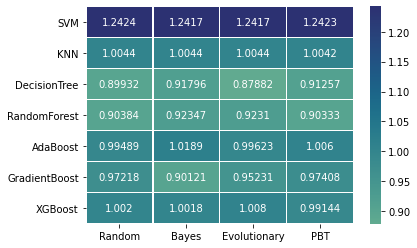

In [ ]:
sns.heatmap(df_score, annot=True, cmap='crest', center=1., fmt='.5g', linecolor='white', linewidths=0.5)

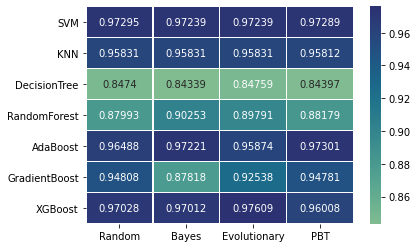

In [ ]:
sns.heatmap(df_score_tuned, annot=True, cmap='crest', center=0.9, fmt='.5g', linecolor='white', linewidths=0.5)

In [ ]:
#Plotando resultados

plt.figure(figsize=(20,12))
plt.title("Pontuação Relativa")

plt.bar(comb, score)

plt.xticks(rotation=20)

### Visualização dos resultados

#### Pontuações

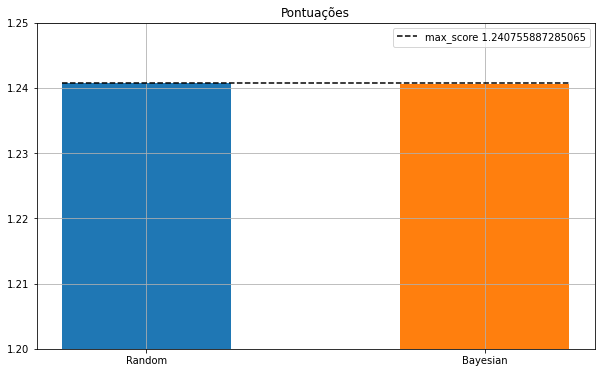

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Pontuações")

#Barras
plt.bar(0, rs.score, width=0.5)
plt.bar(1, bay.score, width=0.5)

#Linha do maior
pontuacoes = [rs.score, bay.score]
max_score = max(pontuacoes)
plt.hlines(max_score, xmin = -0.25, xmax = 1.25, linestyles='dashed', label='max_score '+str(max_score))

plt.ylim(1.20, 1.25)
plt.xticks(np.arange(2),['Random','Bayesian'])
plt.grid()
plt.legend()
plt.show()

#### Tempo

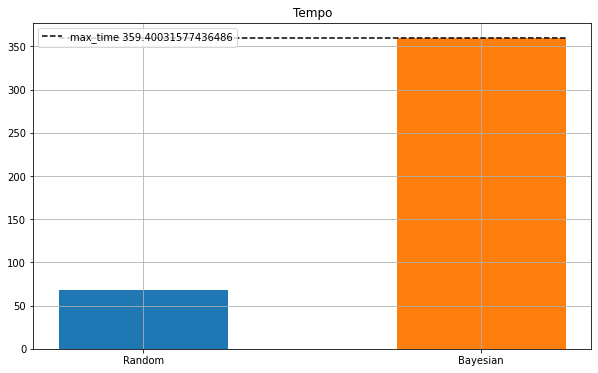

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Tempo")

#Barras
plt.bar(0, rs.time, width=0.5)
plt.bar(1, bay.time, width=0.5)

#Linha do maior
pontuacoes = [rs.time, bay.time]
max_time = max(pontuacoes)
plt.hlines(max_time, xmin = -0.25, xmax = 1.25, linestyles='dashed', label='max_time '+str(max_time))

#plt.ylim(1.20, 1.25)
plt.xticks(np.arange(2),['Random','Bayesian'])
plt.grid()
plt.legend()
plt.show()